### *방재기상관측(AWS) 데이터 전처리 일별*
#### - 250개 시군구 기준으로 날씨를 정리함
> 1. 시군구의 위경도와 센서간의 유클리드 거리 계산
    - 시군구 위경도 기준으로 센서들의 위경도로 유클리드 거리를 추출
> 2. 거리 별 가중치를 계산하여 각 날씨 관련 변수를 계산
    - 정리된 시군구와 센서의 거리 정보를 실제 센서 값을 결합함 (온도가 없는 경우를 제거하여 
      실데이터가 존재하는 센서만 사용)
    - 최고, 최저 온도 발생 시각 및 최고풍속 발생 시각은 초 단위로 계산하여 가중치 적용
    - 결합된 센서들 중 top3에 가중치를 적용하여 가 지역별 변수값 추출
    
#### - 가중치 적용 공식
>  - w1 = 1/2 * (1 - {|d-a1|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)})
>  - w2 = 1/2 * (1 - {|d-a2|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)})
>  - w3 = 1/2 * (1 - {|d-a3|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)})

### - 원천 데이터 리스트
>  - sigungu_xy.csv (시군구)
>  - censerinfo.csv (센서데이터)
>  - OBS_AWS_DD_201701_202010.csv (센서별 날씨관련 변수)

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit

spark = SparkSession.builder.master("local[2]") \
                    .appName('sparkedu') \
                    .getOrCreate()
spark

### 1. 250개의 시군구 위경도 로딩하여 전처리

#### 1.1 시군구 위경도 로딩 컬럼 타입 수정 및 sql사용을 위해 데이터셋 등록

In [3]:
SigunguXY = spark\
          .read\
          .option("inferSchema", "true")\
          .option("header", "true")\
          .csv("data/sigungu_xy.csv")
SigunguXY = SigunguXY.withColumn("sigungu_x", SigunguXY.sigungu_x.cast("float")).withColumn("sigungu_y", SigunguXY.sigungu_y.cast("float"))
SigunguXY.createOrReplaceTempView("Sigunguxy")
print(SigunguXY.count())
# 250

250


#### 1.2 검증

In [4]:
print(SigunguXY.count())
print(SigunguXY.distinct().count())
SigunguXY.describe().show()
SigunguXY.show(2)
# 250

250
250
+-------+--------+-------+------------------+------------------+
|summary|    sido|sigungu|         sigungu_x|         sigungu_y|
+-------+--------+-------+------------------+------------------+
|  count|     250|    250|               250|               250|
|   mean|    null|   null|127.63907656860351| 36.41521324157715|
| stddev|    null|   null| 0.912011813226167|1.0729488769413968|
|    min|  강원도| 가평군|         124.67009|         33.254066|
|    max|충청북도| 횡성군|         130.90572|         38.380592|
+-------+--------+-------+------------------+------------------+

+------+-------+---------+---------+
|  sido|sigungu|sigungu_x|sigungu_y|
+------+-------+---------+---------+
|강원도| 강릉시| 128.8759| 37.75211|
|강원도| 고성군|128.46786|38.380592|
+------+-------+---------+---------+
only showing top 2 rows



### 2. 524개의 센서 데이터를 전처리

#### 2.1 데이터 로딩, 컬럼 타입 수정 및 sql사용을 위해 데이터셋 등록

In [5]:
SenserInfo = spark\
          .read\
          .option("inferSchema", "true")\
          .option("header", "true")\
          .csv("data/censerinfo.csv")
SenserInfo = SenserInfo.withColumn("x", SenserInfo.x.cast("float")).withColumn("y", SenserInfo.y.cast("float"))
SenserInfo.createOrReplaceTempView("SenserInfo")
print(SenserInfo.count())
# 1893

1893


#### 2.2 데이터 정리 - 이력관리 되고 있는 센서 위치 정보를 최근으로 데이터로 가져 오고 필요 데이터만 으로 subset을 만듬

In [6]:
print(SenserInfo.distinct().count())
SenserInfo.describe().show()
# SenserInfo.show()
# 1893

1893
+-------+-----------------+-------------------+-------------------+-----------+------------------+------------------+------------------+------------------+------------------+
|summary|         senserid|          startdate|            enddate|sernsername|                 x|                 y|region_1depth_name|region_2depth_name|region_3depth_name|
+-------+-----------------+-------------------+-------------------+-----------+------------------+------------------+------------------+------------------+------------------+
|  count|             1893|               1893|               1893|       1893|              1893|              1893|              1893|              1893|              1893|
|   mean|693.0612783940835|               null|               null|       null|127.53129761419281|36.158902869045704|              null|              null|              null|
| stddev| 174.599815603351|               null|               null|       null|0.9911930175069503|1.3313135706812764|   

#### 2.3 유지되고 있는 센서 이력은 enddate가 공백이고 유지되지 않는 센서는 enddate에 작동 중지 일이 등록 되어 있음 (csv파일에 enddate가 공백인 경우 2222년을 등록)

In [7]:
LastSenserInfo = spark.sql("""
SELECT A.senserid, A.sernsername, A.x AS senser_x, A.y AS senser_y,
        A.region_1depth_name AS senser_region_1,  
        A.region_3depth_name AS senser_region_2,  
        A.region_2depth_name AS senser_region_3
FROM SenserInfo AS A

INNER JOIN (
    SELECT senserid, max(enddate) AS lenddate
    FROM SenserInfo
    GROUP BY senserid
    ) AS B
ON A.senserid = B.senserid
AND A.enddate = B.lenddate

WHERE 1 = 1

""")
LastSenserInfo.createOrReplaceTempView("LastSenserInfo")
LastSenserInfo.describe().show()
print(LastSenserInfo.count())
# 524

+-------+-----------------+-----------+------------------+------------------+---------------+---------------+---------------+
|summary|         senserid|sernsername|          senser_x|          senser_y|senser_region_1|senser_region_2|senser_region_3|
+-------+-----------------+-----------+------------------+------------------+---------------+---------------+---------------+
|  count|              524|        524|               524|               524|            524|            524|            524|
|   mean|679.4561068702291|       null|127.52589231593008|36.187192130634806|           null|           null|           null|
| stddev|184.2299668080408|       null|1.0150116146748691| 1.364833816970453|           null|           null|           null|
|    min|               12|     가거도|          124.6305|           33.1221|         강원도|         가산면|         가평군|
|    max|              978|       횡성|          131.8698|           38.5439|       충청북도|         흑산면|         횡성군|
+-------+-------

### 3. 시군구 와 센서의 위경도 값을 이용하여 유클리드 거리 계산 (250 * 524 = 131000의 조합)

#### 3.1 시군구별 전체 센서의 조합을 위해 full join

In [8]:
Sigungu_dist = spark.sql("""
SELECT *
FROM SigunguXY AS A

FULL JOIN LastSenserInfo AS B

WHERE 1 = 1
-- AND A.sigungu = '강릉시'

""")
Sigungu_dist.createOrReplaceTempView("Sigungu_dist")
print(Sigungu_dist.count())
Sigungu_dist.show(2)
# 250 * 524 = 131000

131000
+------+-------+---------+---------+--------+-----------+--------+--------+---------------+---------------+---------------+
|  sido|sigungu|sigungu_x|sigungu_y|senserid|sernsername|senser_x|senser_y|senser_region_1|senser_region_2|senser_region_3|
+------+-------+---------+---------+--------+-----------+--------+--------+---------------+---------------+---------------+
|강원도| 강릉시| 128.8759| 37.75211|      12| 안면도(감)|126.3167| 36.5333|       충청남도|         안면읍|         태안군|
|강원도| 고성군|128.46786|38.380592|      12| 안면도(감)|126.3167| 36.5333|       충청남도|         안면읍|         태안군|
+------+-------+---------+---------+--------+-----------+--------+--------+---------------+---------------+---------------+
only showing top 2 rows



#### 3.2 유클리드 거리 및 순위 추출 (pyspark dataframe에서 처리 어려워 pandas 객체로 변환하여처리)

In [9]:
# 유클리드 거리 계산 함수
from scipy.spatial import distance
print(distance.euclidean((128.8759061, 37.75210808), (126.3167, 36.5333)))
print(distance.euclidean((128.8759061, 37.75210808), (128.8759061, 37.75210808)))
print(distance.euclidean((0, 0), (365, 365)))

2.8346126716273883
0.0
516.1879502661797


In [10]:
# pyspark dataframe에서 처리 어려워 pandas 객체로 변환하여처리
from scipy.spatial import distance
# print(distance.euclidean((128.8759061, 37.75210808), (126.3167, 36.5333)))
print('변환 전', type(Sigungu_dist))
# Sigunguxy_dist['distance'] = Sigunguxy_dist.map(lambda x : distance.euclidean((x['sigungu_x'], x['sigungu_y']), (x['x'], x['y'])), axis=1)

#유클리드 함수가 안 돌아 가서 pdf로 변환 후 처리
pdf_Sigungu_dist = Sigungu_dist.toPandas()
print('변환 후', type(pdf_Sigungu_dist))
pdf_Sigungu_dist['udistance'] = pdf_Sigungu_dist.apply(lambda x : distance.euclidean((x['sigungu_x'], x['sigungu_y']), (x['senser_x'], x['senser_y'])), axis=1)
# 다시 스파크 프레임으로 변환
Sigungu_dist = spark.createDataFrame(pdf_Sigungu_dist)
Sigungu_dist.createOrReplaceTempView("Sigungu_dist")
print('유클리드 거리 추가 후 다시변환', type(Sigungu_dist))
print(Sigungu_dist.count())
Sigungu_dist.show(2)
# 131000

변환 전 <class 'pyspark.sql.dataframe.DataFrame'>
변환 후 <class 'pandas.core.frame.DataFrame'>
유클리드 거리 추가 후 다시변환 <class 'pyspark.sql.dataframe.DataFrame'>
131000
+------+-------+------------------+------------------+--------+-----------+------------------+-----------------+---------------+---------------+---------------+------------------+
|  sido|sigungu|         sigungu_x|         sigungu_y|senserid|sernsername|          senser_x|         senser_y|senser_region_1|senser_region_2|senser_region_3|         udistance|
+------+-------+------------------+------------------+--------+-----------+------------------+-----------------+---------------+---------------+---------------+------------------+
|강원도| 강릉시| 128.8759002685547| 37.75210952758789|      12| 안면도(감)|126.31670379638672|36.53329849243164|       충청남도|         안면읍|         태안군| 2.834605249867365|
|강원도| 고성군|128.46786499023438|38.380592346191406|      12| 안면도(감)|126.31670379638672|36.53329849243164|       충청남도|         안면읍|         태안군|2.8

### <span style="color:red">  *여기서 시도군 별 top3를 추출하여 모수를 줄여서 진행하면 좋은데 실제 센서 데이터 중 top3에 빠지는 경우가 발생하여 전체를 모든 센서와 비교하여 top3를 추출해야 함 - 로직수정 ㅠㅠ*

### 3. 일/시간별 센서 정보에 정리된 시군구 * 센서데이터 mapping

#### 3.1 날씨정보 로딩 및 필요 정보 정리

In [11]:
AWS = spark\
          .read\
          .option("inferSchema", "true")\
          .option("charset","euc-kr")\
          .option("header", "true")\
          .csv("data/OBS_AWS_DD_201701_202010.csv")
AWS = AWS.toDF("senserid", "sersername", "date", "temp", "ltemp", "ltemptime", "htemp", "htemptime", \
                                               "rainfall", "hwindspeed", "hwindspeedtime", "avgwindspeed", "hwindspeeddeg")
AWS.createOrReplaceTempView("AWS")
print(AWS.count())
AWS.show(2)
AWS.printSchema()
# 702506

702506
+--------+----------+----------+----+-----+---------+-----+---------+--------+----------+--------------+------------+-------------+
|senserid|sersername|      date|temp|ltemp|ltemptime|htemp|htemptime|rainfall|hwindspeed|hwindspeedtime|avgwindspeed|hwindspeeddeg|
+--------+----------+----------+----+-----+---------+-----+---------+--------+----------+--------------+------------+-------------+
|      12|안면도(감)|2017-01-01| 7.1|  4.7|      527| 10.3|     1324|     0.0|       5.8|          1243|         2.2|        200.2|
|      12|안면도(감)|2017-01-02| 7.4|  5.2|     2322| 11.6|     1314|     0.0|       7.1|          1612|         2.2|          7.5|
+--------+----------+----------+----+-----+---------+-----+---------+--------+----------+--------------+------------+-------------+
only showing top 2 rows

root
 |-- senserid: integer (nullable = true)
 |-- sersername: string (nullable = true)
 |-- date: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- ltemp: double (null

In [52]:
AWS.describe().show()

+-------+------------------+----------+----------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|          senserid|sersername|      date|              temp|             ltemp|        ltemptime|             htemp|         htemptime|          rainfall|       hwindspeed|    hwindspeedtime|      avgwindspeed|     hwindspeeddeg|        ltemptime1|       ltemptime_s|       htemptime_s|  hwindspeedtime_s|
+-------+------------------+----------+----------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            702506|    702506|    702506|     

In [30]:
from pyspark.sql.functions import expr
# 최고/최저온도 및 최고풍속 발생 시간은 초단위로 변환하여 가중치 적용 후 시간으로 변환
AWS = AWS.withColumn("ltemptime", AWS.ltemptime.cast("String")) \
                                .withColumn("htemptime", AWS.htemptime.cast("String")) \
                                .withColumn("hwindspeedtime", AWS.hwindspeedtime.cast("String"))

AWS = AWS.withColumn("ltemptime_s", expr("substring(ltemptime, 1, length(ltemptime)-2)").cast("int") * 3600 \
                                 + expr("substring(ltemptime, length(ltemptime)-1, length(ltemptime))").cast("int") * 60 )
AWS = AWS.withColumn("htemptime_s", expr("substring(htemptime, 1, length(htemptime)-2)").cast("int") * 3600 \
                                 + expr("substring(htemptime, length(htemptime)-1, length(htemptime))").cast("int") * 60 )
AWS = AWS.withColumn("hwindspeedtime_s", expr("substring(hwindspeedtime, 1, length(hwindspeedtime)-2)").cast("int") * 3600 \
                                 + expr("substring(hwindspeedtime, length(hwindspeedtime)-1, length(hwindspeedtime))").cast("int") * 60 )

AWS.createOrReplaceTempView("AWS")

print(AWS.count())
AWS.show(2)
# AWS.printSchema()
# 702506

702506
+--------+----------+----------+----+-----+---------+-----+---------+--------+----------+--------------+------------+-------------+----------+-----------+-----------+----------------+
|senserid|sersername|      date|temp|ltemp|ltemptime|htemp|htemptime|rainfall|hwindspeed|hwindspeedtime|avgwindspeed|hwindspeeddeg|ltemptime1|ltemptime_s|htemptime_s|hwindspeedtime_s|
+--------+----------+----------+----+-----+---------+-----+---------+--------+----------+--------------+------------+-------------+----------+-----------+-----------+----------------+
|      12|안면도(감)|2017-01-01| 7.1|  4.7|      527| 10.3|     1324|     0.0|       5.8|          1243|         2.2|        200.2|     19620|      19620|      48240|           45780|
|      12|안면도(감)|2017-01-02| 7.4|  5.2|     2322| 11.6|     1314|     0.0|       7.1|          1612|         2.2|          7.5|     84120|      84120|      47640|           58320|
+--------+----------+----------+----+-----+---------+-----+---------+--------+---

In [31]:
SigunguWeather = spark.sql("""
SELECT A.sido, A.sigungu, B.senserid, B.sersername
       , A.udistance, B.date, B.temp, B.ltemp
       , B.ltemptime_s
       , B.htemp
       , B.htemptime_s
       , B.rainfall, B.hwindspeed
       , B.hwindspeedtime_s
       , B.avgwindspeed, B.hwindspeeddeg
FROM Sigungu_dist AS A

INNER JOIN AWS AS B
ON A.senserid = B.senserid
AND B.temp is not null
AND B.ltemp is not null 
AND B.htemp is not null
-- 센서 이상으로 온도가 나오지 않는 센서는 제거 하고 key별로 가까운 센서를 추출
WHERE 1 = 1

""")
SigunguWeather.createOrReplaceTempView("SigunguWeather")
print(SigunguWeather.count())
SigunguWeather.show(2)
# SigunguWeather.describe().show() # 개 오래 걸림 ㅋㅋ
# 175545250 # 하나의 센서가 여러 sigungu에서 쓰일 수 있음 ㅋㅋㅋㅋ 일 4년치 2억건 
# 온도의 null 제거 후 174405250

174405250
+------+-------+--------+----------+------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+
|  sido|sigungu|senserid|sersername|         udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|
+------+-------+--------+----------+------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+
|강원도| 강릉시|     964|      마량|3.8845102818642188|2019-07-09|22.0| 20.0|      20940| 25.5|      42180|     0.0|       7.8|           19440|         1.6|         25.3|
|강원도| 강릉시|     964|      마량|3.8845102818642188|2019-07-10|20.8| 20.1|      79680| 22.1|      13560|    20.5|      17.1|           20040|         3.7|         78.8|
+------+-------+--------+----------+------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+--

#### 3.2 유클리드 거리에 따라 작은 순으로 key별로 순위를 주고 top3 추출

In [32]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# 시군구 기준으로 센서들의 udistance에 따라 순위를 줌 
windowSpec  = Window.partitionBy("sido", "sigungu", "date").orderBy("udistance")
SigunguWeather = SigunguWeather.withColumn("row_number", row_number().over(windowSpec))

SigunguWeather.createOrReplaceTempView("SigunguWeather")

print(SigunguWeather.count())
SigunguWeather.show(2)
# 174405250

174405250
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+
|  sido|sigungu|senserid|sersername|          udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|row_number|
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+
|강원도| 강릉시|     524|      강문|0.05938647192316765|2017-04-13|13.7|  6.3|      22260| 18.6|      65760|     0.0|      11.5|           78840|         3.8|        225.0|         1|
|강원도| 강릉시|     566|      연곡|0.11451445804311591|2017-04-13|13.6|  3.7|      23700| 18.1|      72600|     0.0|      11.7|           79500|         3.2|        241.9|         2|
+------+-------+--------+----------+-------------------+----------+----+-----+--------

In [33]:
# udistance에 따른 순위 중 상위 3개만 추출
SigunguSenserTop3 = spark.sql("""
    SELECT *
    FROM SigunguWeather 
    WHERE 1 = 1
    AND row_number IN (1, 2, 3)
    """)
SigunguSenserTop3.createOrReplaceTempView("SigunguSenserTop3")
print(SigunguSenserTop3.count())
SigunguSenserTop3.show(2)
# 2017	365
# 2018	365
# 2019	365
# 2020	305
# 합게 1400
# 1050000 = 250sigungu * 3senser * 1400days

1050000
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+
|  sido|sigungu|senserid|sersername|          udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|row_number|
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+
|강원도| 강릉시|     524|      강문|0.05938647192316765|2017-04-13|13.7|  6.3|      22260| 18.6|      65760|     0.0|      11.5|           78840|         3.8|        225.0|         1|
|강원도| 강릉시|     566|      연곡|0.11451445804311591|2017-04-13|13.6|  3.7|      23700| 18.1|      72600|     0.0|      11.7|           79500|         3.2|        241.9|         2|
+------+-------+--------+----------+-------------------+----------+----+-----+----------

#### 3.3 검증

In [16]:
# 시간 좀 걸림
maxSql = spark.sql("""
    SELECT sido
        , sigungu
        , date
        , count(*)
    FROM SigunguSenserTop3
    WHERE 1 = 1
    GROUP BY sido, sigungu, date
    HAVING count(*) < 3
""")
maxSql.show()

+----+-------+----+--------+
|sido|sigungu|date|count(1)|
+----+-------+----+--------+
+----+-------+----+--------+



In [17]:
# This function use to print feature with null values and null count 
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

# 겁나 오래 돌아 감 결과를 못 봤음 ㅋ
# null_columns_count_list = null_value_count(SigunguSenserTop3)
# null_columns_count_list

In [18]:
# 겁나 오래 돌아 감 ㅋ
# LastSenserInfo.describe().show()

### 4. 센서와 시군구 거리에 의한 가중치 구하기

In [34]:
# w1 = 1/2 * [1 - {|d-a1|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)}]
# w2 = 1/2 * [1 - {|d-a2|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)}]
# w3 = 1/2 * [1 - {|d-a3|/(|d-a1| + |d-a2| + |d-a3| + |d-a4|)}]
from pyspark.sql.functions import row_number, sum

windowSp  = Window.partitionBy("sido", "sigungu", "date")
SigunguSenserTop3 = SigunguSenserTop3.withColumn("sumUdist", sum(SigunguSenserTop3.udistance).over(windowSp))

SigunguSenserTop3 = SigunguSenserTop3.withColumn("weight", (1/2 * (1 - SigunguSenserTop3.udistance / SigunguSenserTop3.sumUdist)))
SigunguSenserTop3.createOrReplaceTempView("SigunguSenserTop3")
print(SigunguSenserTop3.count())
SigunguSenserTop3.show(2)

1050000
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+------------------+------------------+
|  sido|sigungu|senserid|sersername|          udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|row_number|          sumUdist|            weight|
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+------------------+------------------+
|강원도| 강릉시|     524|      강문|0.05938647192316765|2017-04-13|13.7|  6.3|      22260| 18.6|      65760|     0.0|      11.5|           78840|         3.8|        225.0|         1|0.3301074297032258| 0.410049779890508|
|강원도| 강릉시|     566|      연곡|0.11451445804311591|2017-04-13|13.6|  3.7|      23700| 18.1|      72600|     0.0|   

In [35]:
maxSql = spark.sql("""
    SELECT *
    FROM SigunguSenserTop3
    WHERE 1 = 1
    AND sido = '강원도'
    AND sigungu = '강릉시'
    AND date = '2017-08-02'
""")
maxSql.show()

+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+------------------+------------------+
|  sido|sigungu|senserid|sersername|          udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|row_number|          sumUdist|            weight|
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+------------------+------------------+
|강원도| 강릉시|     524|      강문|0.05938647192316765|2017-08-02|24.5| 22.3|      86160| 27.5|      58500|     1.0|       4.2|           52680|         1.2|         92.8|         1|0.3301074297032258| 0.410049779890508|
|강원도| 강릉시|     566|      연곡|0.11451445804311591|2017-08-02|24.0| 22.0|      86280| 27.2|      53580|     0.0|       4.5|

### 5. 가중치를 적용한 일별 시군구의 날씨 정보 추출

In [36]:
# 각 변수에 가중치를 적용함
SigunguSenserTop3_w = spark.sql("""
    SELECT   *
            ,temp             * weight  AS w_temp
            ,ltemp            * weight  AS w_ltemp
            ,ltemptime_s      * weight  AS w_ltemptime
            ,htemp            * weight  AS w_htemp
            ,htemptime_s      * weight  AS w_htemptime
            ,rainfall         * weight  AS w_rainfall
            ,hwindspeed       * weight  AS w_hwindspeed
            ,hwindspeedtime_s * weight  AS w_hwindspeedtime
            ,avgwindspeed     * weight  AS w_avgwindspeed
            ,hwindspeeddeg    * weight  AS w_hwindspeeddeg
    FROM SigunguSenserTop3 
    WHERE 1 = 1
    """)
SigunguSenserTop3_w.createOrReplaceTempView("SigunguSenserTop3_w")
print(SigunguSenserTop3_w.count())
SigunguSenserTop3_w.show(2)
# 1050000

1050000
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+----------+------------------+------------------+------------------+-----------------+
|  sido|sigungu|senserid|sersername|          udistance|      date|temp|ltemp|ltemptime_s|htemp|htemptime_s|rainfall|hwindspeed|hwindspeedtime_s|avgwindspeed|hwindspeeddeg|row_number|          sumUdist|            weight|           w_temp|           w_ltemp|      w_ltemptime|          w_htemp|       w_htemptime|w_rainfall|      w_hwindspeed|  w_hwindspeedtime|    w_avgwindspeed|  w_hwindspeeddeg|
+------+-------+--------+----------+-------------------+----------+----+-----+-----------+-----+-----------+--------+----------+----------------+------------+-------------+----------+---------

In [37]:
# 각 변수에 가중치를 적용함
AWS_D_Weather = spark.sql("""
    SELECT  date  
            ,sido
            ,sigungu
            
            ,sum(w_temp)                 AS w_temp
            ,sum(w_ltemp)                AS w_ltemp
            ,sum(w_ltemptime)            AS w_ltemptime
            ,sum(w_htemp)                AS w_htemp
            ,sum(w_htemptime)            AS w_htemptime
            ,sum(w_rainfall)             AS w_rainfall
            ,sum(w_hwindspeed)           AS w_hwindspeed
            ,sum(w_hwindspeedtime)       AS w_hwindspeedtime
            ,sum(w_avgwindspeed)         AS w_avgwindspeed
            ,sum(w_hwindspeeddeg)        AS w_hwindspeeddeg
            
    FROM SigunguSenserTop3_w 
    WHERE 1 = 1
    GROUP BY date  
            ,sido
            ,sigungu
    """)
AWS_D_Weather.createOrReplaceTempView("AWS_D_Weather")
print(AWS_D_Weather.count())
AWS_D_Weather.show(2)
# 250 * 1400 = 350000

350000
+----------+------+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|      date|  sido|sigungu|            w_temp|          w_ltemp|       w_ltemptime|           w_htemp|      w_htemptime|       w_rainfall|      w_hwindspeed|  w_hwindspeedtime|    w_avgwindspeed|   w_hwindspeeddeg|
+----------+------+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|2017-04-13|강원도| 강릉시|13.377604469065904|4.450048817007544|22714.427553572947|18.305024889945255|70743.50133767226|              0.0|11.907730603837361|  80319.8452522141| 3.314329613472731|233.49511586988083|
|2017-07-10|강원도| 강릉시|24.808224353540442|22.56905437975049| 27684.87302435447| 27.87747881573593|56444.75116137962|5.748451492417361| 6.4716

In [40]:
# 판다스 데이터 프레임으로 변환
pdf_AWS_D_Weather = AWS_D_Weather.toPandas()

In [59]:
# 최고최저 온도 최고 시간은 이전 데이터로 null 처리
display(pdf_AWS_D_Weather.isnull().sum())
pdf_AWS_D_Weather.sort_values(by=['sido', 'sigungu', 'date'], axis=0, inplace=True)
pdf_AWS_D_Weather.head()
pdf_AWS_D_Weather.fillna(method='ffill', inplace=True)
display(pdf_AWS_D_Weather.isnull().sum())

date                   0
sido                   0
sigungu                0
w_temp                 0
w_ltemp                0
w_ltemptime         4925
w_htemp                0
w_htemptime         5735
w_rainfall             0
w_hwindspeed           0
w_hwindspeedtime     962
w_avgwindspeed         0
w_hwindspeeddeg        0
dtype: int64

date                0
sido                0
sigungu             0
w_temp              0
w_ltemp             0
w_ltemptime         0
w_htemp             0
w_htemptime         0
w_rainfall          0
w_hwindspeed        0
w_hwindspeedtime    0
w_avgwindspeed      0
w_hwindspeeddeg     0
dtype: int64

In [62]:
# 초단위 시간대를 시분초로 변환
import datetime

pdf_AWS_D_Weather['w_ltemptime'] = pdf_AWS_D_Weather.apply(lambda x : str(datetime.timedelta(seconds=int(x['w_ltemptime']))), axis=1)
pdf_AWS_D_Weather['w_htemptime'] = pdf_AWS_D_Weather.apply(lambda x : str(datetime.timedelta(seconds=int(x['w_htemptime']))), axis=1)
pdf_AWS_D_Weather['w_hwindspeedtime'] = pdf_AWS_D_Weather.apply(lambda x : str(datetime.timedelta(seconds=int(x['w_hwindspeedtime']))), axis=1)

pdf_AWS_D_Weather.head()

,date,sido,sigungu,w_temp,w_ltemp,w_ltemptime,w_htemp,w_htemptime,w_rainfall,w_hwindspeed,w_hwindspeedtime,w_avgwindspeed,w_hwindspeeddeg
269416,2017-01-01,강원도,강릉시,4.557234,-0.796997,3:40:23,10.387915,13:51:37,0.000000,10.125283,12:51:38,3.179169,255.027907
133027,2017-01-02,강원도,강릉시,7.690979,1.879169,2:37:57,12.436935,11:12:52,0.000000,10.988283,9:49:03,3.054999,246.435575
274657,2017-01-03,강원도,강릉시,4.897704,-1.451651,5:42:25,12.014665,15:04:36,0.000000,10.284832,19:53:07,2.362395,252.371792
250241,2017-01-04,강원도,강릉시,4.570954,0.088274,5:00:07,10.287035,12:58:16,0.000000,9.027933,3:02:46,2.166265,282.039939
1792,2017-01-05,강원도,강릉시,2.572370,-0.857547,2:25:07,4.165100,11:25:17,12.564826,4.735486,11:58:51,1.454925,275.761487


In [64]:
# csv로 저장
pdf_AWS_D_Weather.to_csv("./AWS_D_Weather.csv", index = False)

In [71]:
seoulFlag = pdf_AWS_D_Weather['sido'] == '서울특별시'
pdf_AWS_D_Weather_test = pdf_AWS_D_Weather[seoulFlag]
display(pdf_AWS_D_Weather_test)

,date,sido,sigungu,w_temp,w_ltemp,w_ltemptime,w_htemp,w_htemptime,w_rainfall,w_hwindspeed,w_hwindspeedtime,w_avgwindspeed,w_hwindspeeddeg
16655,2017-01-01,서울특별시,강남구,3.925950,-0.527513,5:47:29,7.836203,14:26:46,0.000000,3.364248,14:39:51,0.988814,112.273149
197291,2017-01-02,서울특별시,강남구,6.507507,3.979062,23:51:57,9.839681,14:23:36,0.179012,6.183773,14:58:37,1.639481,262.983579
100727,2017-01-03,서울특별시,강남구,3.882540,0.597054,6:15:01,7.768177,13:43:14,0.000000,6.023254,14:10:00,1.643109,251.385550
307271,2017-01-04,서울특별시,강남구,5.518443,2.533107,5:19:58,9.435853,14:43:57,0.000000,6.683673,13:43:22,1.403679,296.677995
119980,2017-01-05,서울특별시,강남구,5.350667,1.372437,3:32:32,8.243360,15:29:53,0.000000,6.727815,15:27:11,1.929478,87.415873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,2020-10-27,서울특별시,중랑구,12.926625,7.194362,5:14:56,19.701803,13:59:40,0.000000,5.620435,15:18:00,0.951547,261.681193
16830,2020-10-28,서울특별시,중랑구,13.681471,9.323339,23:25:34,19.492967,12:39:43,0.000000,7.184118,14:34:40,1.420448,279.156485
149874,2020-10-29,서울특별시,중랑구,10.158045,3.575833,6:57:40,16.317353,13:42:12,0.000000,5.092123,14:55:16,1.107033,235.156527
34621,2020-10-30,서울특별시,중랑구,10.642815,3.969452,6:48:19,18.597545,14:38:41,0.000000,4.540256,13:11:05,1.002775,68.541943


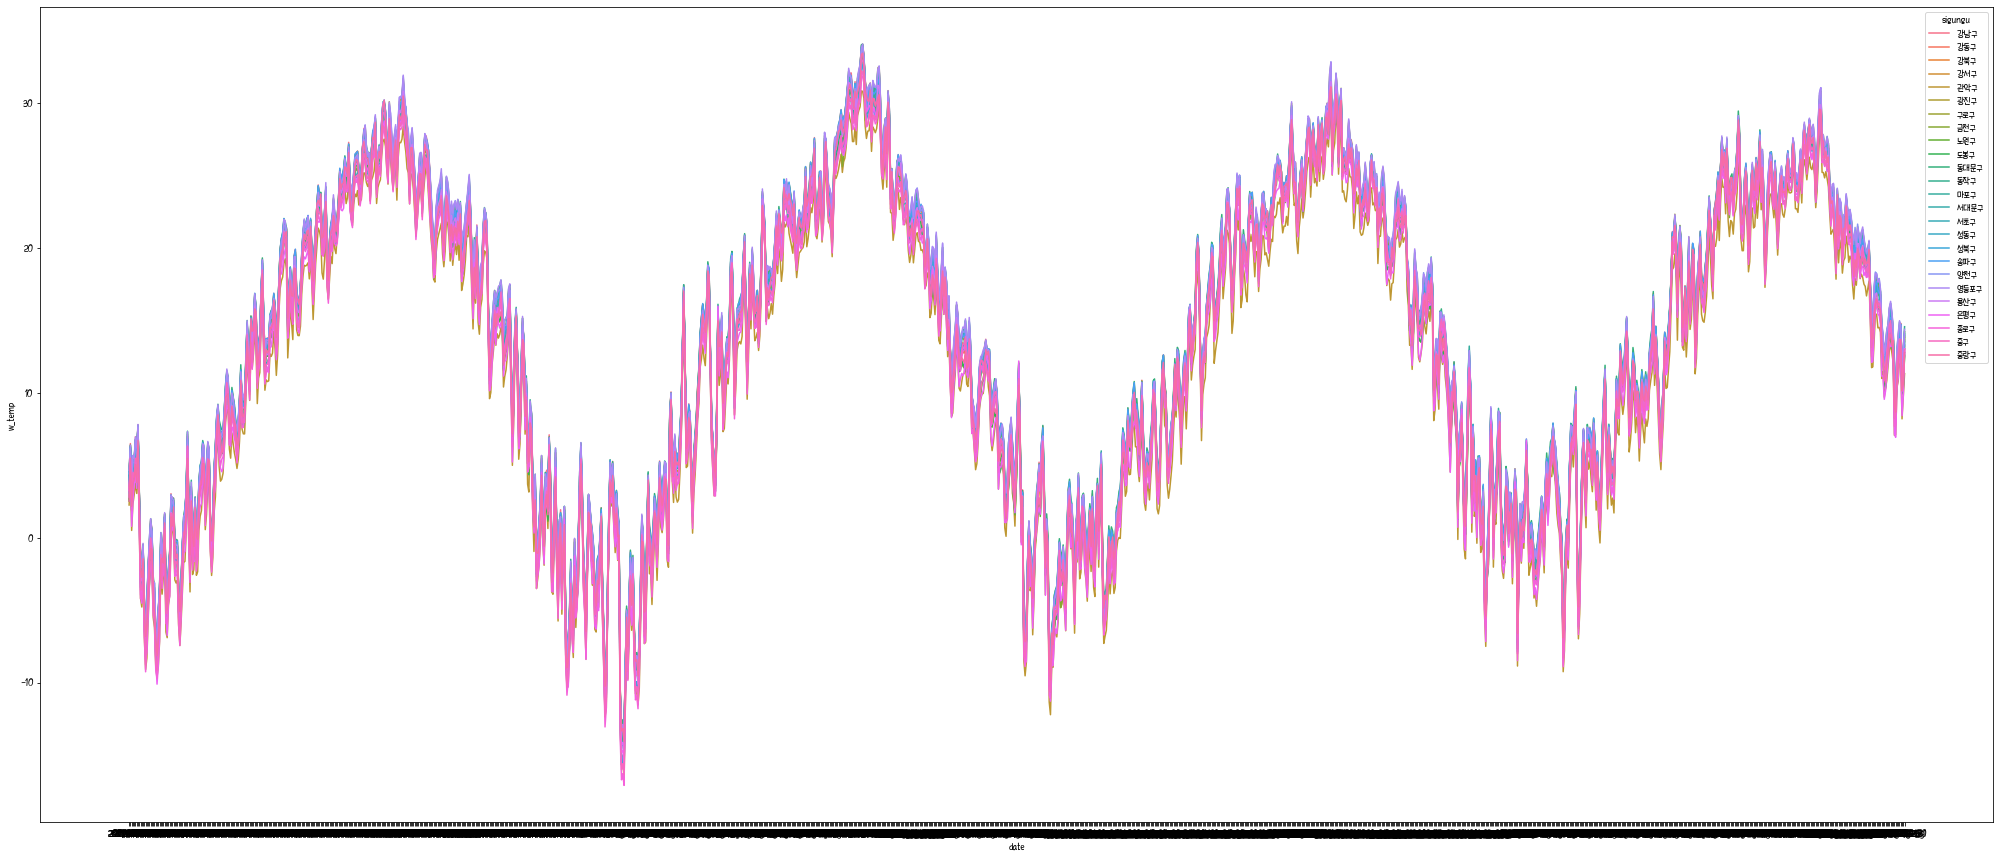

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# matplotlib 한글 폰트 오류 문제 해결
from matplotlib import font_manager, rc
font_path = "C:/PyStexam/data/THEdog.ttf"   #폰트파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.figure(figsize=(35, 15))
sns.lineplot(x="date", y="w_temp", hue="sigungu", data=pdf_AWS_D_Weather_test)
plt.show()

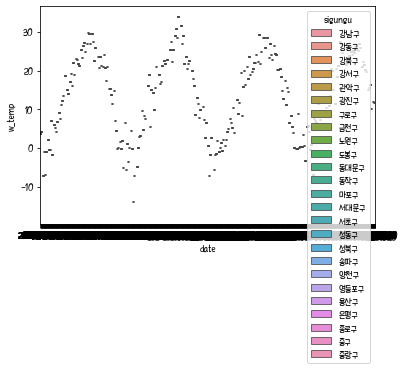

In [73]:
plt.figure(figsize=(35, 15))
sns.boxplot(x='date', y='w_temp', hue='sigungu', data=pdf_AWS_D_Weather_test) 
plt.show()